In [36]:
import pandas as pd
import os
import numpy as np
import plotly.graph_objects as go
# os.chdir(r"G:\Mój dysk")

In [3]:
df = pd.read_csv("./dystrybucja_warzyw.csv")
# mitosheet.sheet(df, analysis_to_replay="id-eheqhoslfn")

In [4]:
fig = go.Figure()
dystrybutor = 'Bio Ananasy i Papryki Magazyn'
towar = 'Jabłka'

k = df.loc[(df['Dystrybutor']==dystrybutor) & (df['Towar']==towar)]
min_date_plot, max_date_plot = k['Data'].min(), k['Data'].max()

fig.add_trace(go.Scatter(x = k['Data'], y = k['Quantity'], name="Quantity"))

for i in k.loc[(k['Quantity']>0)]['Data'].unique():
    fig.add_vline(x=i,line_width=1.5, line_dash="dash", line_color="green", name="Order")
                
fig.update_layout(title_text="{} - {}".format(dystrybutor, towar), title_x=0.5, title_font_color="blue", title_font_size=20,
                              legend_title="", xaxis=dict(rangeselector=dict(buttons=list([dict(step="all"), 
                                                                dict(count=1, label="1m", step="month", stepmode="backward"),
                                                                dict(count=3, label="3m", step="month", stepmode="backward"),
                                                                dict(count=6, label="6m", step="month", stepmode="backward"),
                                                                dict(count=1, label="1y", step="year", stepmode="backward")
                                                                ])), 
                        rangeslider=dict(visible=True), type="date", range = [min_date_plot, max_date_plot]))
    
fig.update_xaxes(rangeslider_thickness = 0.2)
fig.update_layout(autosize=False, width=1500, height=400,)
fig.update_layout(showlegend=True)
fig.show()

In [5]:
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter, ParetoNBDFitter, ModifiedBetaGeoFitter

In [6]:
def clv_week(df, start_date, clv_horizons = [3], level=['Dystrybutor']):
    
    min_date = pd.to_datetime(df['Data'].min())
    max_date = pd.to_datetime(df['Data'].max())
    df['Data'] = pd.to_datetime(df['Data'])
    
    clv_all = pd.DataFrame()
    date_range = pd.date_range(start = start_date, end = max_date, freq="W-MON") 
    # print(date_range)
    
    for date in date_range:
        df_clv = df.loc[(df['Data']<=date)] 
        
        if 'Towar' in level: 
            df_clv['Dystrybutor_Towar'] = df_clv['Dystrybutor'] + '$' + df_clv['Towar']
        else: 
            df_clv['Dystrybutor_Towar'] = df_clv['Dystrybutor']
        
        clv = lifetimes.utils.summary_data_from_transaction_data(df_clv, 'Dystrybutor_Towar', 'Data', 'Quantity')
        clv = clv.loc[clv['monetary_value']>0]
        
        bg_fitter = BetaGeoFitter(penalizer_coef=0.01)
        bg_fitter.fit(clv['frequency'], clv['recency'], clv['T'])
        
        pareto_fitter = ParetoNBDFitter(penalizer_coef = 0.01)
        pareto_fitter.fit(clv["frequency"], clv["recency"], clv["T"])
        
        ggf = GammaGammaFitter(penalizer_coef=0.01)
        ggf.fit(clv["frequency"], clv["monetary_value"])
        
        clv['Data'] = date
        clv['p_alive'] = bg_fitter.conditional_probability_alive(clv["frequency"], clv["recency"], clv["T"]).round(3)
        
        for clv_horizon in clv_horizons:
            clv['Exp_Orders_'+str(clv_horizon)+'M'] = bg_fitter.conditional_expected_number_of_purchases_up_to_time(clv_horizon*30, clv['frequency'].values, clv['recency'], clv['T']).round(3)            
            clv['CLV_'+str(clv_horizon)+'M'] = ggf.customer_lifetime_value(bg_fitter, clv["frequency"], clv["recency"], clv["T"], clv["monetary_value"],
                                                                                         time = clv_horizon, freq = 'D', discount_rate=0)
            
        clv.drop(columns = ['frequency', 'recency', 'T'], errors='ignore', inplace=True)
        
        if date==date_range[0]:
            clv_all = clv.copy()
        else: 
            clv_all = pd.concat([clv_all, clv], axis=0)
    
    clv_all = clv_all.reset_index()
    
    if 'Towar' in level:
        clv_all['Dystrybutor'] = clv_all['Dystrybutor_Towar'].str.split('$').str[0]
        clv_all['Towar'] = clv_all['Dystrybutor_Towar'].str.split('$').str[1]
        clv_all.drop(columns=['Dystrybutor_Towar'], inplace=True)
        clv_all = clv_all[['Dystrybutor', 'Towar', 'Data', 'p_alive', 'monetary_value'] + clv_all.filter(regex='Exp|CLV|Sales').columns.tolist()] 
    else:
        clv_all.rename(columns = {'Dystrybutor_Towar':'Dystrybutor'}, inplace=True)
    
    return clv_all

In [7]:
clv_warzywa = clv_week(df = df, start_date = '2022-01-15', clv_horizons = [3], level=['Dystrybutor', 'Towar'])

In [8]:
clv_warzywa.sort_values(['Dystrybutor','Towar','Data'])

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M
32646,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-09-26,0.912,73.900000,1.868,156.712878
34082,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-03,0.898,73.900000,1.740,145.910578
35524,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-10,0.879,73.900000,1.609,135.016845
36983,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-17,0.867,73.900000,1.508,126.497649
38463,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-24,0.850,73.900000,1.405,117.787674
...,...,...,...,...,...,...,...
142071,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-11-27,0.994,60.607895,4.907,298.467170
144150,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-12-04,0.991,60.607895,4.843,294.546224
146232,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-12-11,0.987,60.607895,4.771,290.185735
148318,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-12-18,0.980,60.607895,4.692,285.385912


In [10]:
fig = go.Figure()
dystrybutor = 'Naturalne Ananasy i Brokuły Dystrybutor'
towar = 'Jabłka'

k = df.loc[(df['Dystrybutor']==dystrybutor) & (df['Towar']==towar)]
min_date_plot, max_date_plot = k['Data'].min(), k['Data'].max()

# fig.add_trace(go.Scatter(x = k['Data'], y = k['Quantity'], name="Quantity"))

k_clv = clv_warzywa.loc[(clv_warzywa['Dystrybutor']==dystrybutor) & (clv_warzywa['Towar']==towar)]
# fig.add_trace(go.Scatter(x = k_clv['Data'], y = k_clv['p_alive'], line = dict(shape = 'linear', color = 'red', dash = 'solid'),  name="p_alive"))
fig.add_trace(go.Scatter(x = k_clv['Data'], y = k_clv['CLV_3M'], line = dict(shape = 'linear', color = 'darkblue', dash = 'solid'), name="CLV_3M"))

for i in k.loc[(k['Quantity']>0)]['Data'].unique():
    fig.add_vline(x=i,line_width=1.5, line_dash="dash", line_color="green", name="Order")
                
fig.update_layout(title_text="{} - {}".format(dystrybutor, towar), title_x=0.5, title_font_color="blue", title_font_size=20,
                              legend_title="", xaxis=dict(rangeselector=dict(buttons=list([dict(step="all"), 
                                                                dict(count=1, label="1m", step="month", stepmode="backward"),
                                                                dict(count=3, label="3m", step="month", stepmode="backward"),
                                                                dict(count=6, label="6m", step="month", stepmode="backward"),
                                                                dict(count=1, label="1y", step="year", stepmode="backward")
                                                                ])), 
                        rangeslider=dict(visible=True), type="date", range = [min_date_plot, max_date_plot]))
    
fig.update_xaxes(rangeslider_thickness = 0.2)
fig.update_layout(autosize=False, width=1500, height=400,)
fig.update_layout(showlegend=True)
fig.show()

### Building segmentation

In [11]:
clv_warzywa

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M
0,Bio Ananasy i Cebule Magazyn,Jabłka,2022-01-17,0.261,74.700000,2.191,188.360434
1,Ekologiczne Ananasy i Brokuły Firma,Pomidory malinowe,2022-01-17,0.294,59.800000,2.701,188.359472
2,Ekologiczne Maliny i Szpinak Sp. z o.o.,Ziemniaki,2022-01-17,0.758,70.300000,8.764,661.756213
3,Ekologiczne Mandarynki i Sałata Firma,Jabłka,2022-01-17,0.202,74.700000,1.693,145.579620
4,Ekologiczne Pomarańcze i Dynie Sp. z o.o.,Ziemniaki,2022-01-17,0.512,149.500000,3.702,619.995838
...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641


In [23]:

r_labels = range(1,6) # the lower recency, the better (higher p_alive, better)
f_labels = range(1,6) # the higher frequency, the better
m_labels = range(1,6) # the higher monetary, the better

rfm = clv_warzywa[clv_warzywa["Data"] == "2023-12-25"]

r_quartiles = pd.qcut(rfm['p_alive'], q=5, labels = r_labels).astype(int)
f_quartiles = pd.qcut(rfm['Exp_Orders_3M'],q=5, labels = f_labels).astype(int)
m_quartiles = pd.qcut(rfm['CLV_3M'],q=5,labels = m_labels).astype(int)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
rfm["RF_Segment"] = rfm["R"].astype('str') + rfm["F"].astype('str')
rfm["RFM_Segment"] = rfm["R"].astype('str') + rfm["F"].astype('str') + rfm["M"].astype('str')
rfm['Score'] = rfm[['R','F','M']].sum(axis=1).astype('int')

rfm

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,R,F,M,RF_Segment,RFM_Segment,Score
148319,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2023-12-25,0.742,73.450000,1.092,81.424978,3,3,4,33,334,10
148320,Bio Ananasy i Cebule Magazyn,Jabłka,2023-12-25,0.001,61.533333,0.000,0.030946,1,1,1,11,111,3
148321,Bio Ananasy i Cebule Sp. z o.o.,Papryka,2023-12-25,0.092,75.200000,0.032,2.740476,1,1,1,11,111,3
148322,Bio Ananasy i Dynie Firma,Jabłka,2023-12-25,0.064,8.800000,0.020,0.274237,1,1,1,11,111,3
148323,Bio Ananasy i Dynie Firma,Ziemniaki,2023-12-25,0.715,73.100000,1.051,77.694394,3,3,4,33,334,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888,3,4,4,34,344,11
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557,3,4,5,34,345,12
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316,3,4,4,34,344,11
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641,5,5,5,55,555,15


In [24]:
rf_seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

# https://documentation.bloomreach.com/engagement/docs/rfm-segmentation
rfm_seg_map = {
    r'111|112|121|131|141|151': 'Lost Customers',
    # r'111|112|121|131|141|151': 'Losing But Engaged',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'155|154|144|214|215|115|114|113': 'Can\'t Loose',
    r'331|321|312|221|213|231|241|251': 'About to Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'543|444|435|355|354|345|344|335': 'Loyal Customers',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalists',
    r'555|554|544|545|454|455|445': 'Champions'
}

score_seg_map = {'Dead':0, 'Green':1, 'Bronze':2, 'Silver':3, 'Gold':4, 'Platinum':5}

In [25]:
rfm['RF_Seg'] = rfm['RF_Segment'].replace(rf_seg_map, regex=True)
rfm['RFM_Seg'] = rfm['RFM_Segment'].replace(rfm_seg_map, regex=True)
rfm

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,R,F,M,RF_Segment,RFM_Segment,Score,RF_Seg,RFM_Seg
148319,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2023-12-25,0.742,73.450000,1.092,81.424978,3,3,4,33,334,10,Need Attention,Need Attention
148320,Bio Ananasy i Cebule Magazyn,Jabłka,2023-12-25,0.001,61.533333,0.000,0.030946,1,1,1,11,111,3,Hibernating,Lost Customers
148321,Bio Ananasy i Cebule Sp. z o.o.,Papryka,2023-12-25,0.092,75.200000,0.032,2.740476,1,1,1,11,111,3,Hibernating,Lost Customers
148322,Bio Ananasy i Dynie Firma,Jabłka,2023-12-25,0.064,8.800000,0.020,0.274237,1,1,1,11,111,3,Hibernating,Lost Customers
148323,Bio Ananasy i Dynie Firma,Ziemniaki,2023-12-25,0.715,73.100000,1.051,77.694394,3,3,4,33,334,10,Need Attention,Need Attention
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888,3,4,4,34,344,11,Loyal Customers,Loyal Customers
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557,3,4,5,34,345,12,Loyal Customers,Loyal Customers
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316,3,4,4,34,344,11,Loyal Customers,Loyal Customers
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641,5,5,5,55,555,15,Champions,Champions


In [26]:
rfm['RFM_Score'] = 'Green'
rfm.loc[rfm['Score']>5,'RFM_Score'] = 'Bronze' 
rfm.loc[rfm['Score']>7,'RFM_Score'] = 'Silver' 
rfm.loc[rfm['Score']>9,'RFM_Score'] = 'Gold' 
rfm.loc[rfm['Score']>10,'RFM_Score'] = 'Platinum'
rfm.drop(columns=['Score'], errors = 'ignore', inplace=True)
        
rfm['Score'] = rfm['RFM_Score'].replace(score_seg_map, regex=True)

In [27]:
rfm

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,R,F,M,RF_Segment,RFM_Segment,RF_Seg,RFM_Seg,RFM_Score,Score
148319,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2023-12-25,0.742,73.450000,1.092,81.424978,3,3,4,33,334,Need Attention,Need Attention,Gold,4
148320,Bio Ananasy i Cebule Magazyn,Jabłka,2023-12-25,0.001,61.533333,0.000,0.030946,1,1,1,11,111,Hibernating,Lost Customers,Green,1
148321,Bio Ananasy i Cebule Sp. z o.o.,Papryka,2023-12-25,0.092,75.200000,0.032,2.740476,1,1,1,11,111,Hibernating,Lost Customers,Green,1
148322,Bio Ananasy i Dynie Firma,Jabłka,2023-12-25,0.064,8.800000,0.020,0.274237,1,1,1,11,111,Hibernating,Lost Customers,Green,1
148323,Bio Ananasy i Dynie Firma,Ziemniaki,2023-12-25,0.715,73.100000,1.051,77.694394,3,3,4,33,334,Need Attention,Need Attention,Gold,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888,3,4,4,34,344,Loyal Customers,Loyal Customers,Platinum,5
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557,3,4,5,34,345,Loyal Customers,Loyal Customers,Platinum,5
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316,3,4,4,34,344,Loyal Customers,Loyal Customers,Platinum,5
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641,5,5,5,55,555,Champions,Champions,Platinum,5


In [29]:
rfm_rfm = rfm[['p_alive','Exp_Orders_3M','CLV_3M']]
print(rfm_rfm.describe())

           p_alive  Exp_Orders_3M       CLV_3M
count  2090.000000    2090.000000  2090.000000
mean      0.651982       1.525999    98.025548
std       0.372712       2.121470   189.703426
min       0.000000       0.000000     0.000007
25%       0.264500       0.175250     6.897348
50%       0.851000       0.928000    40.326207
75%       0.966000       2.013750   119.527469
max       0.999000      30.407000  3102.614701


C:\Users\rados\AppData\Local\Temp\ipykernel_19556\3370320224.py:6: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



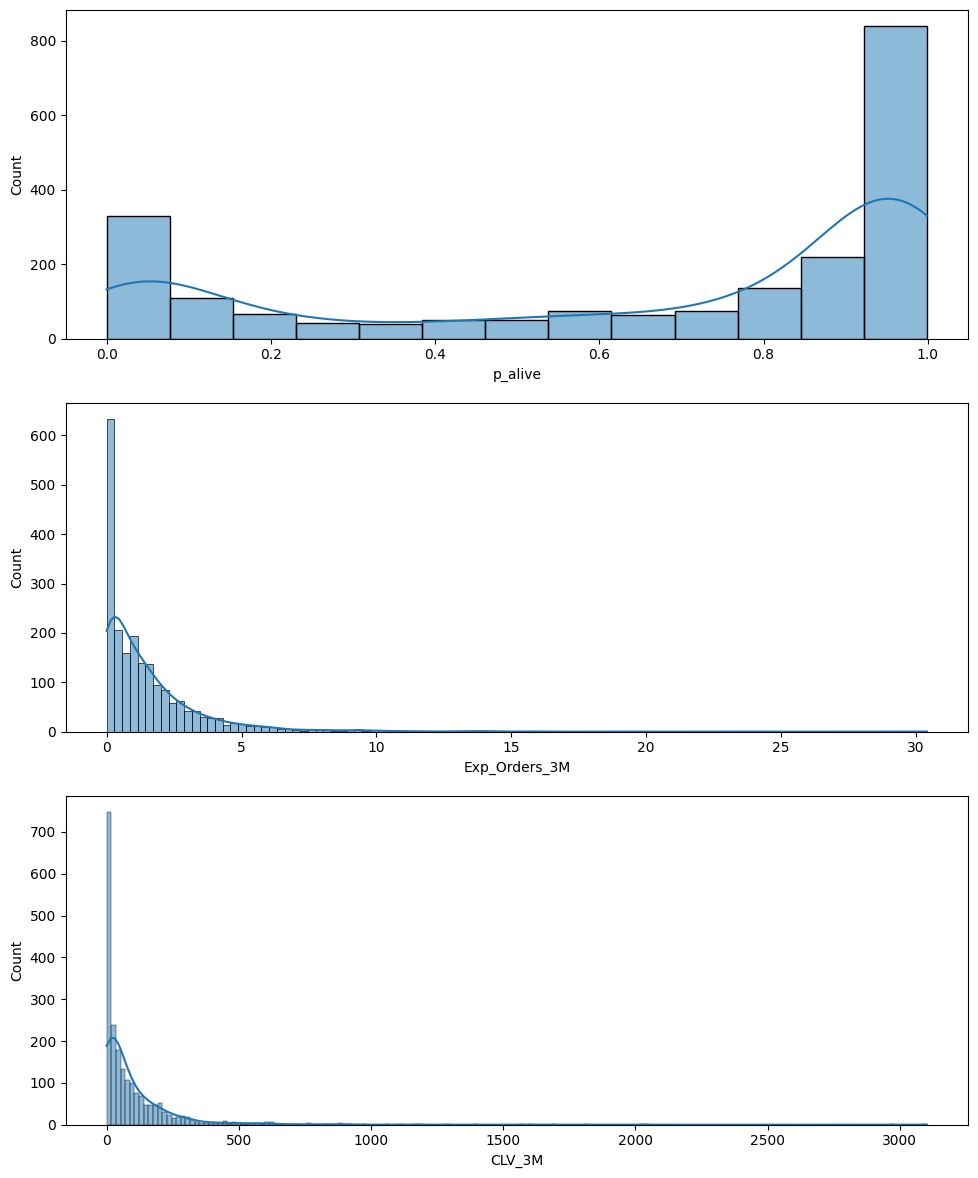

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 12))

plt.subplot(3, 1, 1)
sns.histplot(rfm.p_alive, label = 'p_alive', kde=True)

plt.subplot(3, 1, 2)
sns.histplot(rfm.Exp_Orders_3M, label = 'Exp_Orders_3M', kde=True)

plt.subplot(3, 1, 3)
sns.histplot(rfm.CLV_3M, label = 'CLV_3M', kde=True)

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [39]:
# Apply log transformation to address skewness

# Apply log transformation to address skewness
# rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

## Pytanie - czy usuwamy uśmiercionych konsumentów ??? (p_alive == 0)
rfm_log = rfm[['Exp_Orders_3M','CLV_3M', 'p_alive']]


### K-mean clustering

In [40]:
# Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

# Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)
rfm_normalized = pd.DataFrame(rfm_normalized, columns = ['p_alive','Exp_Orders_3M','CLV_3M'])
rfm_normalized

,p_alive,Exp_Orders_3M,CLV_3M
0,-0.204624,-0.087529,0.241579
1,-0.719484,-0.516691,-1.747028
2,-0.704397,-0.502405,-1.502813
3,-0.710055,-0.515408,-1.577956
4,-0.223955,-0.107199,0.169119
...,...,...,...
2085,-0.122585,0.041534,0.531416
2086,0.421507,0.436512,0.679019
2087,0.190480,0.198651,0.365028
2088,0.774177,0.348849,0.917866


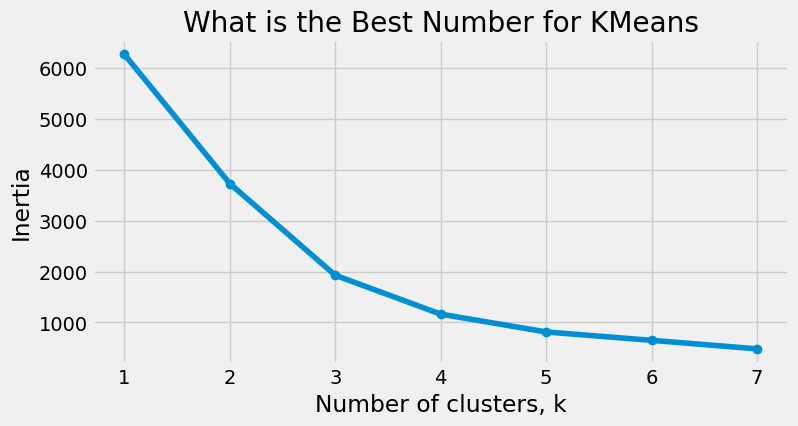

In [41]:
from sklearn.cluster import KMeans

#First : Get the Best KMeans 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(8, 4))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.title('What is the Best Number for KMeans')
plt.show()